In [5]:
from trainer import *
import cv2


with open('configs/basic_config.yaml') as file:
    config = yaml.full_load(file)
 
trainer = Trainer(config)


Saving checkpoint..
Initializing samples..


In [2]:
dataset = trainer.dataset
s = dataset.__getitem__(10)

array([0.33553426, 0.01814677, 1.10474336])

array([-0.30135079, -0.0188718 , -0.99963057])

In [3]:
def plt_tensor(img, proj_img=False):
    img = (np.transpose(img.cpu().numpy(), (1, 2, 0)))
    
    print(img.shape)
    
    if not proj_img:
        img = 0.5 + (img * 0.5)
    return img

# Create a sample

In [6]:
batch    = next(iter(trainer.train_loader))

In [7]:
tgt        = batch['tgt']
ref_imgs   = batch['ref_imgs']
intrinsics = batch['intrinsics']
poses      = batch['oxts']
depth      = batch['groundtruth']
batch_option  = 0
pose_option   = 0

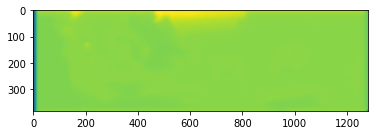

In [25]:
warped_sample = cv2.imread('./images/depth/0.png', cv2.IMREAD_GRAYSCALE)

plt.imshow(warped_sample)
# tgt_img = tgt[batch_option]
# ref_img = ref_imgs[pose_option][batch_option]
# K = intrinsics[batch_option]

# fig, axs = plt.subplots(2, 3, figsize=(40, 10)) 
# axs[0, 0].imshow(plt_tensor(ref_imgs[0][1]))
# axs[0, 1].imshow(plt_tensor(tgt[1]))
# axs[0, 2].imshow(plt_tensor(ref_imgs[1][1]))
# axs[1, 0].imshow(warped_sample)
# axs[1, 1].imshow(warped_sample)
# axs[1, 2].imshow(warped_sample)

In [31]:
warped_sample.max()

215

In [192]:
C, H, W = depth.shape
depth = depth.view(C, -1)
val, _= depth.max(1)
val = val.unsqueeze(1)

print(depth[0].max())

depth = depth.sub(val)
depth = depth.reshape(C, H, W )
print(depth[0].max())

tensor(1.)
tensor(0.)


torch.Size([4, 384, 1280])


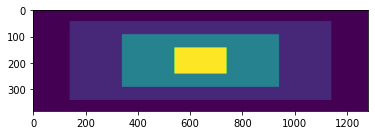

In [201]:
def create_mul_mask(tensor):
    
    mul_mask = torch.ones_like(tensor)
    
    C, H, W     = mul_mask.shape
    c_h, c_w = H//2, W//2
    
    mul_mask[:, c_h-150:c_h+150, c_w-500:c_w+500] = 2
    mul_mask[:, c_h-100:c_h+100, c_w-300:c_w+300] = 5
    mul_mask[:, c_h-50:c_h+50, c_w-100:c_w+100]   = 10
    
    return mul_mask

mask = create_mul_mask(depth)
print(mask.shape)
plot_img = mask.cpu().detach().numpy()
plt.imshow(plot_img[3])

In [203]:
new = depth * mask

torch.Size([4, 384, 1280])

# Inference

In [147]:
one_sample = trainer.dataset.__getitem__(100)


# load a depth model
depth_model = trainer.depth_model
# depth_model.load_state_dict(depth_model_state_dict)
depth_model.eval()

# load a pose model
pose_model = trainer.pose_model
# pose_model.load_state_dict(pose_model_state_dict)
pose_model.eval()

# test input image
input_imgs = one_sample['tgt'].unsqueeze(0).to(trainer.device)
ref_imgs   = [img.unsqueeze(0).to(trainer.device) for img in one_sample['ref_imgs']]

with torch.no_grad():
    # test and plot
    depth = depth_model(input_imgs)
    pose  = pose_model(input_imgs, ref_imgs)

print(depth)
print(pose)



(tensor([[[[0.4944, 0.4790, 0.4731,  ..., 0.4695, 0.4775, 0.4652],
          [0.4841, 0.4686, 0.4561,  ..., 0.4527, 0.4699, 0.4588],
          [0.4901, 0.4748, 0.4642,  ..., 0.4597, 0.4687, 0.4565],
          ...,
          [0.4822, 0.4736, 0.4544,  ..., 0.4606, 0.4691, 0.4608],
          [0.4850, 0.4851, 0.4705,  ..., 0.4715, 0.4756, 0.4688],
          [0.4881, 0.4875, 0.4757,  ..., 0.4770, 0.4795, 0.4835]]]],
       device='cuda:0'), tensor([[[[0.5043, 0.4852, 0.4869,  ..., 0.5069, 0.5037, 0.4989],
          [0.5186, 0.5183, 0.5170,  ..., 0.5333, 0.5291, 0.5107],
          [0.5252, 0.5279, 0.5269,  ..., 0.5503, 0.5397, 0.5194],
          ...,
          [0.5105, 0.5179, 0.5285,  ..., 0.5730, 0.5531, 0.5209],
          [0.5072, 0.5121, 0.5267,  ..., 0.5469, 0.5328, 0.5153],
          [0.5046, 0.5162, 0.5209,  ..., 0.5186, 0.5090, 0.5068]]]],
       device='cuda:0'), tensor([[[[0.5023, 0.5121, 0.5085,  ..., 0.5010, 0.4992, 0.5068],
          [0.5049, 0.5010, 0.5117,  ..., 0.5033, 0.4991

array([[0.49436775, 0.47900835, 0.4730955 , ..., 0.4695116 , 0.47751385,
        0.46521625],
       [0.48411146, 0.4685929 , 0.45611757, ..., 0.45270562, 0.46988526,
        0.45883307],
       [0.49008006, 0.474848  , 0.46418568, ..., 0.45968914, 0.46873808,
        0.45647132],
       ...,
       [0.48216033, 0.47356686, 0.45437858, ..., 0.46057788, 0.46906373,
        0.46079925],
       [0.48499084, 0.48512048, 0.47052562, ..., 0.4714816 , 0.47555912,
        0.4688402 ],
       [0.48805243, 0.48750627, 0.47573033, ..., 0.47698915, 0.47946608,
        0.48349673]], dtype=float32)

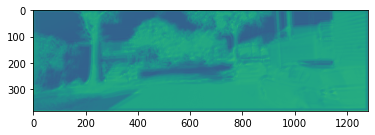

In [148]:
img = depth[0].squeeze().cpu().detach().numpy()
plt.imshow(img)
img

array([[0.20207189, 0.20853782, 0.21113865, ..., 0.2127469 , 0.20918912,
        0.21470699],
       [0.20634411, 0.21316311, 0.2189806 , ..., 0.22062737, 0.21257807,
        0.21768744],
       [0.2038362 , 0.21036105, 0.21518265, ..., 0.21728292, 0.21309723,
        0.21881127],
       ...,
       [0.20717739, 0.21092895, 0.21981683, ..., 0.21686456, 0.2129496 ,
        0.21676059],
       [0.20597073, 0.20591581, 0.21228938, ..., 0.21185985, 0.21004716,
        0.21305092],
       [0.2046813 , 0.20491014, 0.20997173, ..., 0.20941874, 0.20833914,
        0.20660593]], dtype=float32)

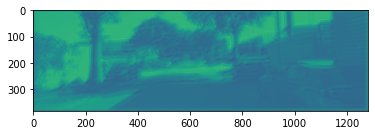

In [162]:
def disp_to_depth(disp, min_depth=0.1, max_depth=100.0):
        """Convert network's sigmoid output into depth prediction
        The formula for this conversion is given in the 'additional considerations'
        section of the paper.
        """
        min_disp = 1 / max_depth
        max_disp = 1 / min_depth

        scaled_disp = min_disp + (max_disp - min_disp) * disp
        depth = 1 / scaled_disp
        return depth

depth = disp_to_depth(img)


norm = (depth - depth.min()) /(depth.max() - depth.min())
plt.imshow(norm)
depth

8.641329

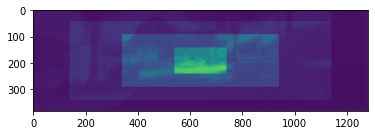

In [164]:
depth = norm * create_mul_mask(depth)
plt.imshow(depth)
depth.max()

In [53]:
from __future__ import absolute_import, division, print_function

import numpy as np

import torch
import torch.nn as nn
import torchvision.models as models

class ResnetEncoder(nn.Module):
    """Pytorch module for a resnet encoder
    """
    def __init__(self, num_layers, pretrained, num_input_images=1):
        super(ResnetEncoder, self).__init__()

        self.num_ch_enc = np.array([64, 64, 128, 256, 512])

        resnets = {18: models.resnet18,
                   34: models.resnet34,
                   50: models.resnet50,
                   101: models.resnet101,
                   152: models.resnet152}

        if num_layers not in resnets:
            raise ValueError("{} is not a valid number of resnet layers".format(num_layers))

        if num_input_images > 1:
            self.encoder = resnet_multiimage_input(num_layers, pretrained, num_input_images)
        else:
            self.encoder = resnets[num_layers](pretrained)

        if num_layers > 34:
            self.num_ch_enc[1:] *= 4

    def forward(self, input_image):
        self.features = []
        # x = (input_image - 0.45) / 0.225
        x = input_image
        x = self.encoder.conv1(x)
        x = self.encoder.bn1(x)
        self.features.append(self.encoder.relu(x))
        self.features.append(self.encoder.layer1(self.encoder.maxpool(self.features[-1])))
        self.features.append(self.encoder.layer2(self.features[-1]))
        self.features.append(self.encoder.layer3(self.features[-1]))
        self.features.append(self.encoder.layer4(self.features[-1]))

        return self.features

In [54]:
# Adapted from monodepth2
# https://github.com/nianticlabs/monodepth2/blob/master/layers.py

from __future__ import absolute_import, division, print_function

import torch.nn as nn
import torch.nn.functional as F


def disp_to_depth(disp, min_depth, max_depth):
    """Convert network's sigmoid output into depth prediction
    The formula for this conversion is given in the 'additional considerations'
    section of the paper.
    """
    min_disp = 1 / max_depth
    max_disp = 1 / min_depth
    scaled_disp = min_disp + (max_disp - min_disp) * disp
    depth = 1 / scaled_disp
    return scaled_disp, depth


class ConvBlock(nn.Module):
    """Layer to perform a convolution followed by ELU
    """
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()

        self.conv = Conv3x3(in_channels, out_channels)
        self.nonlin = nn.ELU(inplace=True)

    def forward(self, x):
        out = self.conv(x)
        out = self.nonlin(out)
        return out


class Conv3x3(nn.Module):
    """Layer to pad and convolve input
    """
    def __init__(self, in_channels, out_channels, use_refl=True):
        super(Conv3x3, self).__init__()

        if use_refl:
            self.pad = nn.ReflectionPad2d(1)
        else:
            self.pad = nn.ZeroPad2d(1)
        self.conv = nn.Conv2d(int(in_channels), int(out_channels), 3)

    def forward(self, x):
        out = self.pad(x)
        out = self.conv(out)
        return out


def upsample(x):
    """Upsample input tensor by a factor of 2
    """
    return F.interpolate(x, scale_factor=2, mode="nearest")


In [55]:
from collections import OrderedDict


class DepthDecoder(nn.Module):
    def __init__(self, num_ch_enc, scales=range(4), num_output_channels=1, use_skips=True):
        super(DepthDecoder, self).__init__()

        self.num_output_channels = num_output_channels
        self.use_skips = use_skips
        self.upsample_mode = 'nearest'
        self.scales = scales

        self.num_ch_enc = num_ch_enc
        self.num_ch_dec = np.array([16, 32, 64, 128, 256])

        # decoder
        self.convs = OrderedDict()
        for i in range(4, -1, -1):
            # upconv_0
            num_ch_in = self.num_ch_enc[-1] if i == 4 else self.num_ch_dec[i + 1]
            num_ch_out = self.num_ch_dec[i]
            self.convs[("upconv", i, 0)] = ConvBlock(num_ch_in, num_ch_out)

            # upconv_1
            num_ch_in = self.num_ch_dec[i]
            if self.use_skips and i > 0:
                num_ch_in += self.num_ch_enc[i - 1]
            num_ch_out = self.num_ch_dec[i]
            self.convs[("upconv", i, 1)] = ConvBlock(num_ch_in, num_ch_out)

        for s in self.scales:
            self.convs[("dispconv", s)] = Conv3x3(self.num_ch_dec[s], self.num_output_channels)

        self.decoder = nn.ModuleList(list(self.convs.values()))
        self.sigmoid = nn.Sigmoid()

    def forward(self, input_features):
        self.outputs = {}

        # decoder
        x = input_features[-1]
        for i in range(4, -1, -1):
            x = self.convs[("upconv", i, 0)](x)
            x = [upsample(x)]
            if self.use_skips and i > 0:
                x += [input_features[i - 1]]
            x = torch.cat(x, 1)
            x = self.convs[("upconv", i, 1)](x)
            if i in self.scales:
                self.outputs[("disp", i)] = self.sigmoid(self.convs[("dispconv", i)](x))

        return self.outputs

In [79]:
decoder_model = DepthDecoder(model.num_ch_enc)
model = ResnetEncoder(18, True)

In [80]:
output = model(tgt)
output = decoder_model(output)
disp   = output[('disp', 0)][0] 
depth  = 1/disp

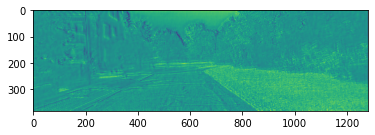

In [81]:
depth = depth.squeeze().cpu().detach().numpy()
plt.imshow(depth)